<a href="https://colab.research.google.com/github/MeidanGR/SpeechEmotionRecognition_Realtime/blob/main/2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [9]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

ModuleNotFoundError: No module named 'tensorflow'

In [5]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"
        
        
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [6]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = 'data'

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
     
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))                   

NameError: name 'librosa' is not defined

In [ ]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 173056 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = 'data' 

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 
    # Pad for duration equalization.
      padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22
       
   # Features extraction 
      f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      
   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]                      

   # Filling the data lists  
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) 

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

**X, Y Setup**

In [8]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (60, 339, 1)
RMS shape: (60, 339, 1)
MFCCs shape: (60, 339, 13)


In [9]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

**Save & Load X,Y to JSON files**

In [10]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist() 
x_path = 'X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = 'Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)


'[[0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [3], [3], [3], [4], [4], [4], [4], [4], [4], [4], [4], [5], [5], [5], [5], [5], [5], [5], [5], [6], [6], [6], [6], [6], [6], [6], [6], [7], [7], [7], [7], [7], [7], [7], [7]]'

In [11]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = 'X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = 'Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [12]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [13]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(52, 339, 15)
(5, 339, 15)
(3, 339, 15)


In [14]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[4], [0], [5]], "dtype": "int8", "shape": [3, 1], "Corder": true}'

In [15]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [17]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = 'best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=340, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 339, 64)           20480     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Train on 52 samples, validate on 5 samples
Epoch 1/340
52/52 [==============================] - 1s 29ms/step - loss: 2.1587 - categorical_accuracy: 0.1154 - val_loss: 2.1143 - val_categorical_accuracy: 0.0000e+00
Epoch 2/340
52/52 [==============================] - 1s 19ms/step - loss: 2.1013 - categorical_accuracy: 0.1538 - val_loss: 2.0855 - val_categorical_accuracy: 0.0

Epoch 45/340
52/52 [==============================] - 1s 18ms/step - loss: 1.6976 - categorical_accuracy: 0.3846 - val_loss: 1.8869 - val_categorical_accuracy: 0.2000
Epoch 46/340
52/52 [==============================] - 1s 18ms/step - loss: 1.5014 - categorical_accuracy: 0.3654 - val_loss: 2.6225 - val_categorical_accuracy: 0.0000e+00
Epoch 47/340
52/52 [==============================] - 1s 19ms/step - loss: 1.4813 - categorical_accuracy: 0.4038 - val_loss: 1.8056 - val_categorical_accuracy: 0.4000
Epoch 48/340
52/52 [==============================] - 1s 18ms/step - loss: 1.3910 - categorical_accuracy: 0.3846 - val_loss: 1.9611 - val_categorical_accuracy: 0.2000
Epoch 49/340
52/52 [==============================] - 1s 19ms/step - loss: 1.3757 - categorical_accuracy: 0.3846 - val_loss: 1.2375 - val_categorical_accuracy: 0.6000
Epoch 50/340
52/52 [==============================] - 1s 18ms/step - loss: 1.7849 - categorical_accuracy: 0.2692 - val_loss: 1.5346 - val_categorical_accuracy: 0

Epoch 94/340
52/52 [==============================] - 1s 19ms/step - loss: 1.4474 - categorical_accuracy: 0.4038 - val_loss: 2.0015 - val_categorical_accuracy: 0.4000
Epoch 95/340
52/52 [==============================] - 1s 18ms/step - loss: 1.3539 - categorical_accuracy: 0.5000 - val_loss: 1.4251 - val_categorical_accuracy: 0.4000
Epoch 96/340
52/52 [==============================] - 1s 18ms/step - loss: 1.1021 - categorical_accuracy: 0.5962 - val_loss: 2.5000 - val_categorical_accuracy: 0.4000
Epoch 97/340
52/52 [==============================] - 1s 17ms/step - loss: 1.1069 - categorical_accuracy: 0.5000 - val_loss: 0.8943 - val_categorical_accuracy: 0.6000
Epoch 98/340
52/52 [==============================] - 1s 18ms/step - loss: 1.1156 - categorical_accuracy: 0.5577 - val_loss: 1.8765 - val_categorical_accuracy: 0.4000
Epoch 99/340
52/52 [==============================] - 1s 18ms/step - loss: 0.9848 - categorical_accuracy: 0.6538 - val_loss: 0.9074 - val_categorical_accuracy: 0.800

Epoch 143/340
52/52 [==============================] - 1s 18ms/step - loss: 0.8767 - categorical_accuracy: 0.6346 - val_loss: 1.8909 - val_categorical_accuracy: 0.2000
Epoch 144/340
52/52 [==============================] - 1s 20ms/step - loss: 0.9911 - categorical_accuracy: 0.5962 - val_loss: 0.8944 - val_categorical_accuracy: 0.6000
Epoch 145/340
52/52 [==============================] - 1s 19ms/step - loss: 1.1345 - categorical_accuracy: 0.5192 - val_loss: 1.4224 - val_categorical_accuracy: 0.4000
Epoch 146/340
52/52 [==============================] - 1s 18ms/step - loss: 0.8184 - categorical_accuracy: 0.6346 - val_loss: 1.0503 - val_categorical_accuracy: 0.6000
Epoch 147/340
52/52 [==============================] - 1s 20ms/step - loss: 0.8422 - categorical_accuracy: 0.6346 - val_loss: 1.2397 - val_categorical_accuracy: 0.4000
Epoch 148/340
52/52 [==============================] - 1s 20ms/step - loss: 0.7299 - categorical_accuracy: 0.6923 - val_loss: 2.3624 - val_categorical_accuracy:

Epoch 192/340
52/52 [==============================] - 1s 17ms/step - loss: 0.6000 - categorical_accuracy: 0.7885 - val_loss: 2.8661 - val_categorical_accuracy: 0.4000
Epoch 193/340
52/52 [==============================] - 1s 17ms/step - loss: 0.5992 - categorical_accuracy: 0.7692 - val_loss: 2.8770 - val_categorical_accuracy: 0.4000
Epoch 194/340
52/52 [==============================] - 1s 17ms/step - loss: 0.5903 - categorical_accuracy: 0.7885 - val_loss: 2.8845 - val_categorical_accuracy: 0.4000
Epoch 195/340
52/52 [==============================] - 1s 17ms/step - loss: 0.5812 - categorical_accuracy: 0.7885 - val_loss: 2.8392 - val_categorical_accuracy: 0.4000
Epoch 196/340
52/52 [==============================] - 1s 17ms/step - loss: 0.5771 - categorical_accuracy: 0.7885 - val_loss: 2.8794 - val_categorical_accuracy: 0.4000
Epoch 197/340
52/52 [==============================] - 1s 17ms/step - loss: 0.5843 - categorical_accuracy: 0.7692 - val_loss: 2.8719 - val_categorical_accuracy:

Epoch 241/340
52/52 [==============================] - 1s 17ms/step - loss: 0.4498 - categorical_accuracy: 0.8462 - val_loss: 2.9008 - val_categorical_accuracy: 0.4000
Epoch 242/340
52/52 [==============================] - 1s 17ms/step - loss: 0.4224 - categorical_accuracy: 0.8654 - val_loss: 2.8039 - val_categorical_accuracy: 0.2000
Epoch 243/340
52/52 [==============================] - 1s 17ms/step - loss: 0.4187 - categorical_accuracy: 0.8654 - val_loss: 2.8658 - val_categorical_accuracy: 0.2000
Epoch 244/340
52/52 [==============================] - 1s 17ms/step - loss: 0.4290 - categorical_accuracy: 0.8462 - val_loss: 2.8033 - val_categorical_accuracy: 0.2000
Epoch 245/340
52/52 [==============================] - 1s 17ms/step - loss: 0.4130 - categorical_accuracy: 0.8654 - val_loss: 2.9627 - val_categorical_accuracy: 0.2000
Epoch 246/340
52/52 [==============================] - 1s 17ms/step - loss: 0.4782 - categorical_accuracy: 0.8462 - val_loss: 2.5833 - val_categorical_accuracy:

Epoch 290/340
52/52 [==============================] - 1s 17ms/step - loss: 0.3709 - categorical_accuracy: 0.8654 - val_loss: 3.0648 - val_categorical_accuracy: 0.2000
Epoch 291/340
52/52 [==============================] - 1s 18ms/step - loss: 0.3703 - categorical_accuracy: 0.8654 - val_loss: 3.0633 - val_categorical_accuracy: 0.2000
Epoch 292/340
52/52 [==============================] - 1s 17ms/step - loss: 0.3698 - categorical_accuracy: 0.8654 - val_loss: 3.0752 - val_categorical_accuracy: 0.2000
Epoch 293/340
52/52 [==============================] - 1s 17ms/step - loss: 0.3696 - categorical_accuracy: 0.8654 - val_loss: 3.0662 - val_categorical_accuracy: 0.2000
Epoch 294/340
52/52 [==============================] - 1s 17ms/step - loss: 0.3691 - categorical_accuracy: 0.8654 - val_loss: 3.0663 - val_categorical_accuracy: 0.2000
Epoch 295/340
52/52 [==============================] - 1s 17ms/step - loss: 0.3688 - categorical_accuracy: 0.8654 - val_loss: 3.0838 - val_categorical_accuracy:

Epoch 339/340
52/52 [==============================] - 1s 17ms/step - loss: 0.3517 - categorical_accuracy: 0.8654 - val_loss: 3.1007 - val_categorical_accuracy: 0.2000
Epoch 340/340
52/52 [==============================] - 1s 18ms/step - loss: 0.3512 - categorical_accuracy: 0.8654 - val_loss: 3.1079 - val_categorical_accuracy: 0.2000


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## **Train (fit) Visualization**

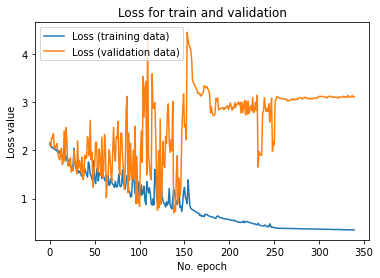

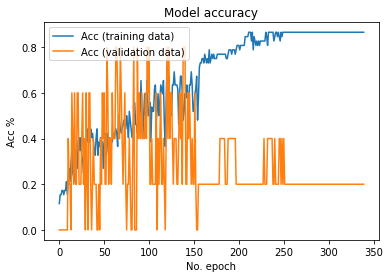

In [19]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()